# Project: Investigate No Show Appointment

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

<p>Data set selected for investigation is No Show Appointment Rate.
There is one dependant variable no show rate,As per data there are more than one independant variable which are use to predict no show rate.We will mainly focus on answering following three question about data set.</p>
<ul>
	<li>1)What are the factors in age will affect show up probability</li>
<li>2)Which gender have more probability of showing up</li>
<li>3)Does SMS reminder make any differance?</li>
</ul>


In [1]:
%matplotlib inline
import numpy as np
import pandas as pds
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab
sns.set_style("whitegrid")


<a id='wrangling'></a>
##2. Data Wrangling

### General Properties

In this section will read the data and show heading top data 

In [2]:
dataSet  = pds.read_csv('data.csv')
print(dataSet.head())

      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0      

### Data Cleaning (Replace this with more specific notes!)

<b>2.1Create uniform datetime format and rename No-show</b>

Will convert scheduleday and appointment day in dattime64 format	

In [4]:
dataSet.ScheduledDay = dataSet.ScheduledDay.apply(np.datetime64)
dataSet.AppointmentDay = dataSet.AppointmentDay.apply(np.datetime64)

dataSet.rename(columns = {'No-show':'noshow'},inplace=True)



There are some typos mistake in data column which we will fix

In [39]:
dataSet.rename(columns = {'Hipertension':'Hypertension',
                         'Handcap': 'Handicap'}, inplace = True)

<b>2.2 Check for currupted data</b>

In [43]:
print('Gender:',dataSet.Gender.unique())
print('ScheduledDay:',dataSet.ScheduledDay.unique())
print('AppointmentDay:',dataSet.AppointmentDay.unique())
print('Age:',sorted(dataSet.Age.unique()))
print('Scholarship',dataSet.Scholarship.unique())
print('Handicap',dataSet.Handicap.unique())
print('Hypertension',dataSet.Hypertension.unique())
print('SMS_received',dataSet.SMS_received.unique())
print('Diabetes',dataSet.Diabetes.unique())
print('Alcoholism',dataSet.Alcoholism.unique())
print('No-show',dataSet.noshow.unique())


Gender: ['F' 'M']
ScheduledDay: ['2016-04-29T18:38:08.000000000' '2016-04-29T16:08:27.000000000'
 '2016-04-29T16:19:04.000000000' ... '2016-04-27T16:03:52.000000000'
 '2016-04-27T15:09:23.000000000' '2016-04-27T13:30:56.000000000']
AppointmentDay: ['2016-04-29T00:00:00.000000000' '2016-05-03T00:00:00.000000000'
 '2016-05-10T00:00:00.000000000' '2016-05-17T00:00:00.000000000'
 '2016-05-24T00:00:00.000000000' '2016-05-31T00:00:00.000000000'
 '2016-05-02T00:00:00.000000000' '2016-05-30T00:00:00.000000000'
 '2016-05-16T00:00:00.000000000' '2016-05-04T00:00:00.000000000'
 '2016-05-19T00:00:00.000000000' '2016-05-12T00:00:00.000000000'
 '2016-05-06T00:00:00.000000000' '2016-05-20T00:00:00.000000000'
 '2016-05-05T00:00:00.000000000' '2016-05-13T00:00:00.000000000'
 '2016-05-09T00:00:00.000000000' '2016-05-25T00:00:00.000000000'
 '2016-05-11T00:00:00.000000000' '2016-05-18T00:00:00.000000000'
 '2016-05-14T00:00:00.000000000' '2016-06-02T00:00:00.000000000'
 '2016-06-03T00:00:00.000000000' '201

It is clear from result that there is age in minus and 0 so we can remove those values

In [6]:
dataSet = dataSet[(dataSet.Age >= 0)]



For Data cleaning following actions are performed:
    1)Correct typos mistake
    2)Check nor NULL and nagative values
    3)Created uniform date time for scheduledday and appointmentday

<a id='eda'></a>
## Exploratory Data Analysis



### What are the factors in age will affect show up probability

In [44]:
bins = [19,20,65,np.inf]
labels=["Child & TeenAge","Adult","Elder"]
age_category = pds.cut(dataSet.Age,bins,labels=labels)
dataSet['Age_cat'] = age_category




In [45]:
def probabilityByCategory(data,groupBy):
    data = dataSet[[groupBy, 'noshow','Scholarship']].groupby([groupBy, 'noshow']).count()
    data = data.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
    std = data.query('noshow=="Yes"')['Scholarship'].std()
    impact = {}
    impact[groupBy] = std
    return data
    

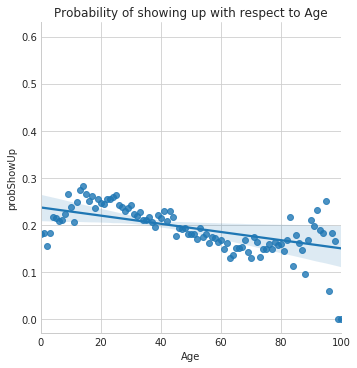

In [46]:


def probStatus(dataset, group_by):
    df = pds.crosstab(index = dataset[group_by], columns = dataset.noshow).reset_index()
    df['probShowUp'] = df['Yes'] / (df['No'] + df['Yes'])
    return df[[group_by, 'probShowUp']]

sns.lmplot(data = probStatus(dataSet, 'Age'), x = 'Age', y = 'probShowUp', fit_reg = True)
plt.xlim(0, 100)
plt.title('Probability of showing up with respect to Age')
plt.show()

From graph it is visible that probability of showing person whose age are 15 to 35 and above 85 are very high.

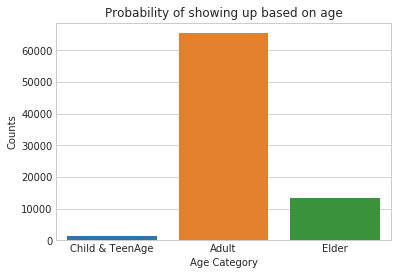

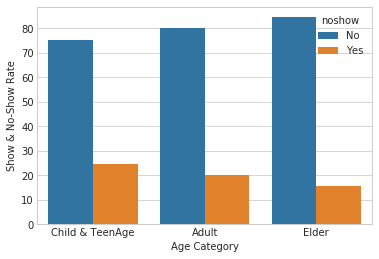

In [47]:
agedata = dataSet.groupby(['Age_cat'])
gps = agedata.size()
sns.barplot(x=gps.index.tolist(), y=gps.values)
plt.title('Probability of showing up based on age')
plt.xlabel('Age Category')
plt.ylabel('Counts')
plt.show()

agedata = probabilityByCategory(agedata,'Age_cat')
sns.barplot(y="Scholarship", x="Age_cat", hue="noshow", data=agedata)
plt.xlabel('Age Category')
plt.ylabel('Show & No-Show Rate')
plt.show()


From graph it is clear that we can not predict base on age differance that which age patient will show up or not as from visualization it seems that it same for all age groups

### Q2:Which gender have more probability of showing up		

We will group the data by Gender recieved and find out that are there is high probability of showing up for appointment based on gender of person.

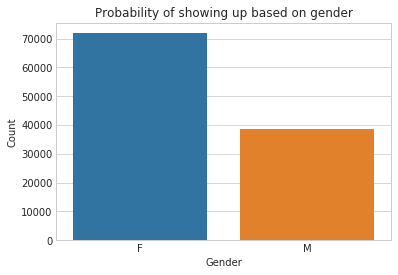

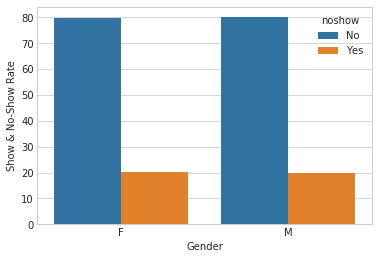

In [48]:
bygender = dataSet.groupby(['Gender'])
gps = bygender.size()
sns.barplot(x=gps.index.tolist(), y=gps.values)
plt.title('Probability of showing up based on gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


bygender = probabilityByCategory(bygender,'Gender')
sns.barplot(y="Scholarship", x="Gender", hue="noshow", data=bygender)
plt.xlabel('Gender')
plt.ylabel('Show & No-Show Rate')
plt.show()


From graph it is clear that we can not predict base on gender differance that which gender patient will show up or not as from visualization it seems that it same for gender

### Q3: Will SMS Reminder will help?

We will group the data by SMS recieved and find out that are there is high probability of showing up for appointment if SMS is recieved.

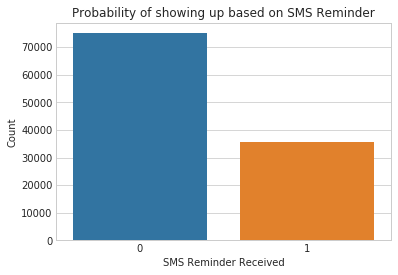

In [51]:


sms = dataSet.groupby(['SMS_received'])
gps = sms.size()
sns.barplot(x=gps.index.tolist(), y=gps.values)
plt.title('Probability of showing up based on SMS Reminder')
plt.xlabel('SMS Reminder Received')
plt.ylabel('Count')
plt.show()



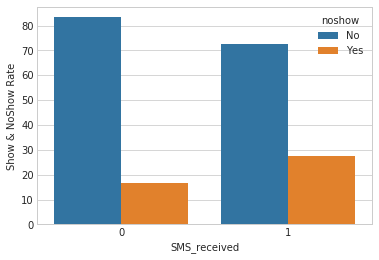

In [52]:
sms = probabilityByCategory(sms,'SMS_received')
sns.barplot(y="Scholarship", x="SMS_received", hue="noshow", data=sms)
plt.ylabel('Show & NoShow Rate')
plt.show()

It is clear from visualization that thare is no much differance in data.But we can say that if SMS is recived there is high chance that patient will showup.

   ### Conclusion:	

I found some limitation on data as follow:
It seems from data that thre is only 3-4 months data present fro schedule Day.There should be some more parameter like seviarity,visit type,person is working or student etc.
Reson for appointment and doctor specialization are also a key point to better visualize data.
These should be a big data about this scenario to better predict no show rate.

From data it is clear that SMS_Recieved,Age,ScheduleDay,Appointment Day are some parameters from whcih we can predict the no show rate.
